In [1]:
import sys
sys.path.append('..')
from run_fft import FFTProcessor
import numpy as np
import pandas as pd

In [2]:
# Enable rpy2
%load_ext rpy2.ipython

In [5]:
# Read raw NLL data

fft_processor = FFTProcessor(method='fft', 
                             preprocess='zscore', 
                             value='norm', 
                             require_sid=False)

est_name = 'gpt2xl'
nll_pubmed_orig = fft_processor._read_data(data_file=f'../data/gpt-4/pubmed_gpt-4.original.{est_name}.nll.txt')
nll_pubmed_samp = fft_processor._read_data(data_file=f'../data/gpt-4/pubmed_gpt-4.sampled.{est_name}.nll.txt')

data = fft_processor._preprocess(nll_pubmed_orig)
df_nllzs_orig = fft_processor._create_input_df(data)
data = fft_processor._preprocess(nll_pubmed_samp)
df_nllzs_samp = fft_processor._create_input_df(data)
df_nllzs_orig['Source'] = 'Human'
df_nllzs_samp['Source'] = 'Model'
df_nllzs = pd.concat([df_nllzs_orig, df_nllzs_samp])

df_nllzs.head()

,value,sid,Source
0,-0.536146,0,Human
1,0.087604,0,Human
2,0.947946,0,Human
3,1.824943,0,Human
4,1.475195,0,Human


`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'


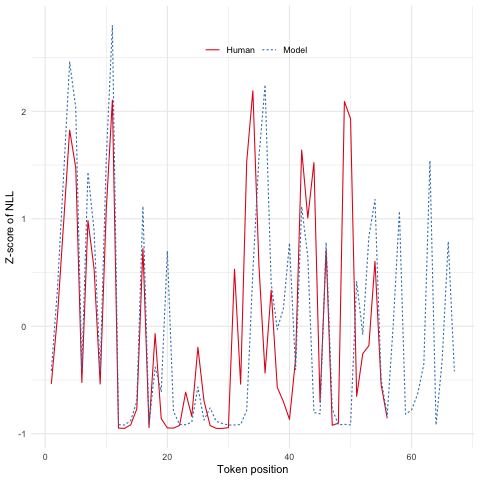

In [40]:
%%R -i df_nllzs
require("data.table")
require("ggplot2")

# Add token position column
dt <- data.table(df_nllzs)
dt[, tokenPos := 1:.N, by=.(Source, sid)]
# head(dt)

# Plot NLL vs. token position
p <- ggplot(dt, aes(x=tokenPos, y=value)) +
    geom_smooth(aes(fill=Source, color=Source)) +
    theme_minimal() +
    theme(legend.position=c(0.5,0.9), legend.title=element_blank(), legend.direction="horizontal") +
    labs(x="Token position", y="Z-score of NLL") +
    scale_color_brewer(palette="Set1") + scale_fill_brewer(palette="Set1")
# plot(p)
ggsave('example_nll_aggregated.pdf', width=3.5, height=2.5)

# Plot two examples of NLL ~ tokenPos
p <- ggplot(dt[sid == 0], aes(x=tokenPos, y=value)) +
    geom_line(aes(color=Source, lty=Source)) +
    theme_minimal() +
    theme(legend.position=c(0.5,0.9), legend.title=element_blank(), legend.direction="horizontal") +
    labs(x="Token position", y="Z-score of NLL") +
    scale_color_brewer(palette="Set1") + scale_fill_brewer(palette="Set1")
plot(p)
ggsave("example_nll.pdf", plot=p, width=3.5, height=2.5)

In [51]:
# Get aggregated NLL for all three datasets

def get_nll_df(est_name='gpt2xl'):
    fft_processor = FFTProcessor(method='fft', 
                             preprocess='zscore', 
                             value='norm', 
                             require_sid=False)
    genre_list = ['pubmed', 'writing', 'xsum']
    df_list = []
    for genre in genre_list:
        nll_orig = fft_processor._read_data(data_file=f'../data/gpt-4/{genre}_gpt-4.original.{est_name}.nll.txt')
        nll_samp = fft_processor._read_data(data_file=f'../data/gpt-4/{genre}_gpt-4.sampled.{est_name}.nll.txt')
        data = fft_processor._preprocess(nll_orig)
        df_nllzs_orig = fft_processor._create_input_df(data)
        data = fft_processor._preprocess(nll_samp)
        df_nllzs_samp = fft_processor._create_input_df(data)
        df_nllzs_orig['Source'] = 'Human'
        df_nllzs_samp['Source'] = 'Model'
        df_nllzs = pd.concat([df_nllzs_orig, df_nllzs_samp])
        df_nllzs['Task'] = genre
        df_list.append(df_nllzs)
    df = pd.concat(df_list)
    return df

df_nllzs_all = get_nll_df(est_name='gpt2xl')
df_nllzs_all.head()

,value,sid,Source,Task
0,-0.536146,0,Human,pubmed
1,0.087604,0,Human,pubmed
2,0.947946,0,Human,pubmed
3,1.824943,0,Human,pubmed
4,1.475195,0,Human,pubmed


In [59]:
%%R -i df_nllzs_all
# Plot aggregated NLL for all three tasks
require("data.table")
require("ggplot2")

# Add token position column
dt <- data.table(df_nllzs_all)
dt[, tokenPos := 1:.N, by=.(Source, sid, Task)]
# head(dt)

# NLL ~ tokenPos
p <- ggplot(dt, aes(x=tokenPos, y=value)) +
    geom_smooth(aes(fill=Source, color=Source, lty=Source)) +
    theme_minimal() + facet_wrap(~Task) + 
    theme(legend.position=c(0.5,0.9), legend.title=element_blank(), legend.direction="horizontal") +
    labs(x="Token position", y="Z-score of NLL") +
    scale_color_brewer(palette="Set1") + scale_fill_brewer(palette="Set1")
# plot(p)

ggsave("heuristics_nll.pdf", plot=p, width=9, height=3)

`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'


`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'
`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'


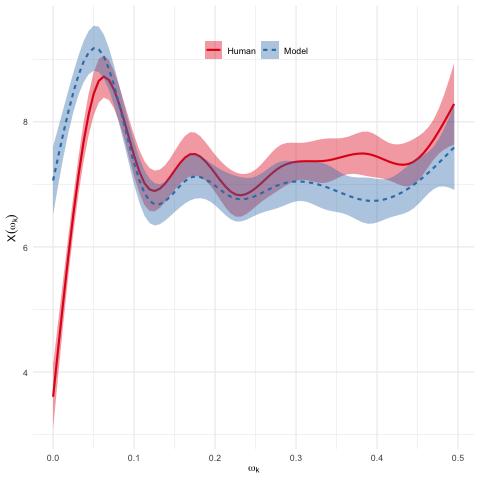

In [38]:
%%R
# Plot examples of FFT norm

d.orig <- fread("../data/gpt-4/pubmed_gpt-4.original.gpt2xl.nllzs.fftnorm.txt")
d.samp <- fread("../data/gpt-4/pubmed_gpt-4.sampled.gpt2xl.nllzs.fftnorm.txt")
d.orig$Source <- "Human"
d.samp$Source <- "Model"
dt <- rbind(d.orig, d.samp)

# Plot example of power~freq
p <- ggplot(dt[sid == 0], aes(x=freq, y=power)) +
    geom_line(aes(color=Source, lty=Source)) +
    theme_minimal() +
    theme(legend.position=c(0.5,0.9), legend.title=element_blank(), legend.direction="horizontal") +
    labs(x = bquote(omega[k]), y = bquote(X(omega[k]))) +
    scale_color_brewer(palette="Set1") + scale_fill_brewer(palette="Set1")
plot(p)
ggsave("example_spectrum.pdf", plot=p, width=3.5, height=2.5)

# Plot aggregated power~freq
p2 <- ggplot(dt, aes(x=freq, y=power)) +
    geom_smooth(aes(color=Source, lty=Source, fill=Source)) +
    theme_minimal() +
    theme(legend.position=c(0.5,0.9), legend.title=element_blank(), legend.direction="horizontal") +
    labs(x = bquote(omega[k]), y = bquote(X(omega[k]))) +
    scale_color_brewer(palette="Set1") + scale_fill_brewer(palette="Set1")
plot(p2)
ggsave("example_spectrum_aggregated.pdf", plot=p2, width=3.5, height=2.5)

In [77]:
%%R
# Plot heuristic 1: low freq difference
# GPT-4 data

require("stringr")

est_name <- "gpt2xl"
# est_name <- "mistral"

pubmed.orig <- fread(str_interp("../data/gpt-4/pubmed_gpt-4.original.${est_name}.nllzs.fftnorm.txt"))
pubmed.samp <- fread(str_interp("../data/gpt-4/pubmed_gpt-4.sampled.${est_name}.nllzs.fftnorm.txt"))
pubmed.orig$Source <- "Human"
pubmed.samp$Source <- "Model"
dt.pubmed <- rbind(pubmed.orig, pubmed.samp)
dt.pubmed$Task <- "PubMed"

writing.orig <- fread(str_interp("../data/gpt-4/writing_gpt-4.original.${est_name}.nllzs.fftnorm.txt"))
writing.samp <- fread(str_interp("../data/gpt-4/writing_gpt-4.sampled.${est_name}.nllzs.fftnorm.txt"))
writing.orig$Source <- "Human"
writing.samp$Source <- "Model"
dt.writing <- rbind(writing.orig, writing.samp)
dt.writing$Task <- "Writing"

xsum.orig <- fread(str_interp("../data/gpt-4/xsum_gpt-4.original.${est_name}.nllzs.fftnorm.txt"))
xsum.samp <- fread(str_interp("../data/gpt-4/xsum_gpt-4.sampled.${est_name}.nllzs.fftnorm.txt"))
xsum.orig$Source <- "Human"
xsum.samp$Source <- "Model"
dt.xsum <- rbind(xsum.orig, xsum.samp)
dt.xsum$Task <- "Xsum"

dt.all <- rbind(dt.pubmed, dt.writing, dt.xsum)

# Plot aggregated power~freq
p <- ggplot(dt.all, aes(x=freq, y=power)) +
    geom_smooth(aes(color=Source, lty=Source, fill=Source), method='lm') +
    theme_minimal() + facet_wrap(~Task) + 
    theme(legend.position=c(0.2,0.9), legend.title=element_blank(), legend.direction="horizontal") +
    labs(x = bquote(omega[k]), y = bquote(X(omega[k]))) +
    scale_color_brewer(palette="Set1") + scale_fill_brewer(palette="Set1")
# plot(p)
ggsave(str_interp("heuristics_gpt-4_${est_name}_lm.pdf"), plot=p, width=7.5, height=2.5)

p <- ggplot(dt.all, aes(x=freq, y=power)) +
    geom_smooth(aes(color=Source, lty=Source, fill=Source), method='gam') +
    theme_minimal() + facet_wrap(~Task) + 
    theme(legend.position=c(0.2,0.9), legend.title=element_blank(), legend.direction="horizontal") +
    labs(x = bquote(omega[k]), y = bquote(X(omega[k]))) +
    scale_color_brewer(palette="Set1") + scale_fill_brewer(palette="Set1")
# plot(p)
ggsave(str_interp("heuristics_gpt-4_${est_name}_gam.pdf"), plot=p, width=7.5, height=2.5)

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ s(x, bs = "cs")'


In [75]:
%%R
# Plot heuristic 1: low freq difference
# GPT-3.5 data

require("stringr")

# est_name <- "gpt2xl"
est_name <- "mistral"

pubmed.orig <- fread(str_interp("../data/gpt-3.5/pubmed_gpt-3.5-turbo.original.${est_name}.nllzs.fftnorm.txt"))
pubmed.samp <- fread(str_interp("../data/gpt-3.5/pubmed_gpt-3.5-turbo.sampled.${est_name}.nllzs.fftnorm.txt"))
pubmed.orig$Source <- "Human"
pubmed.samp$Source <- "Model"
dt.pubmed <- rbind(pubmed.orig, pubmed.samp)
dt.pubmed$Task <- "PubMed"

writing.orig <- fread(str_interp("../data/gpt-3.5/writing_gpt-3.5-turbo.original.${est_name}.nllzs.fftnorm.txt"))
writing.samp <- fread(str_interp("../data/gpt-3.5/writing_gpt-3.5-turbo.sampled.${est_name}.nllzs.fftnorm.txt"))
writing.orig$Source <- "Human"
writing.samp$Source <- "Model"
dt.writing <- rbind(writing.orig, writing.samp)
dt.writing$Task <- "Writing"

xsum.orig <- fread(str_interp("../data/gpt-3.5/xsum_gpt-3.5-turbo.original.${est_name}.nllzs.fftnorm.txt"))
xsum.samp <- fread(str_interp("../data/gpt-3.5/xsum_gpt-3.5-turbo.sampled.${est_name}.nllzs.fftnorm.txt"))
xsum.orig$Source <- "Human"
xsum.samp$Source <- "Model"
dt.xsum <- rbind(xsum.orig, xsum.samp)
dt.xsum$Task <- "Xsum"

dt.all <- rbind(dt.pubmed, dt.writing, dt.xsum)

# Plot aggregated power~freq 
p <- ggplot(dt.all, aes(x=freq, y=power)) +
    geom_smooth(aes(color=Source, lty=Source, fill=Source), method='lm') +
    theme_minimal() + facet_wrap(~Task) + 
    theme(legend.position=c(0.2,0.9), legend.title=element_blank(), legend.direction="horizontal") +
    labs(x = bquote(omega[k]), y = bquote(X(omega[k]))) +
    scale_color_brewer(palette="Set1") + scale_fill_brewer(palette="Set1")
# plot(p)
ggsave(str_interp("heuristics_gpt-3.5_${est_name}_lm.pdf"), plot=p, width=7.5, height=2.5)

p <- ggplot(dt.all, aes(x=freq, y=power)) +
    geom_smooth(aes(color=Source, lty=Source, fill=Source), method='gam') +
    theme_minimal() + facet_wrap(~Task) + 
    theme(legend.position=c(0.2,0.9), legend.title=element_blank(), legend.direction="horizontal") +
    labs(x = bquote(omega[k]), y = bquote(X(omega[k]))) +
    scale_color_brewer(palette="Set1") + scale_fill_brewer(palette="Set1")
# plot(p)
ggsave(str_interp("heuristics_gpt-3.5_${est_name}_gam.pdf"), plot=p, width=7.5, height=2.5)

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ s(x, bs = "cs")'


In [79]:
%%R
# Plot heuristic 1: low freq difference
# GPT-3 (Davinci) data

require("stringr")

est_name <- "gpt2xl"
# est_name <- "mistral"

pubmed.orig <- fread(str_interp("../data/davinci/pubmed_davinci.original.${est_name}.nllzs.fftnorm.txt"))
pubmed.samp <- fread(str_interp("../data/davinci/pubmed_davinci.sampled.${est_name}.nllzs.fftnorm.txt"))
pubmed.orig$Source <- "Human"
pubmed.samp$Source <- "Model"
dt.pubmed <- rbind(pubmed.orig, pubmed.samp)
dt.pubmed$Task <- "PubMed"

writing.orig <- fread(str_interp("../data/davinci/writing_davinci.original.${est_name}.nllzs.fftnorm.txt"))
writing.samp <- fread(str_interp("../data/davinci/writing_davinci.sampled.${est_name}.nllzs.fftnorm.txt"))
writing.orig$Source <- "Human"
writing.samp$Source <- "Model"
dt.writing <- rbind(writing.orig, writing.samp)
dt.writing$Task <- "Writing"

xsum.orig <- fread(str_interp("../data/davinci/xsum_davinci.original.${est_name}.nllzs.fftnorm.txt"))
xsum.samp <- fread(str_interp("../data/davinci/xsum_davinci.sampled.${est_name}.nllzs.fftnorm.txt"))
xsum.orig$Source <- "Human"
xsum.samp$Source <- "Model"
dt.xsum <- rbind(xsum.orig, xsum.samp)
dt.xsum$Task <- "Xsum"

dt.all <- rbind(dt.pubmed, dt.writing, dt.xsum)

# Plot aggregated power~freq
p <- ggplot(dt.all, aes(x=freq, y=power)) +
    geom_smooth(aes(color=Source, lty=Source, fill=Source), method='lm') +
    theme_minimal() + facet_wrap(~Task) + 
    theme(legend.position=c(0.2,0.9), legend.title=element_blank(), legend.direction="horizontal") +
    labs(x = bquote(omega[k]), y = bquote(X(omega[k]))) +
    scale_color_brewer(palette="Set1") + scale_fill_brewer(palette="Set1")
# plot(p)
ggsave(str_interp("heuristics_gpt-3_${est_name}_lm.pdf"), plot=p, width=7.5, height=2.5)

p <- ggplot(dt.all, aes(x=freq, y=power)) +
    geom_smooth(aes(color=Source, lty=Source, fill=Source), method='gam') +
    theme_minimal() + facet_wrap(~Task) + 
    theme(legend.position=c(0.2,0.9), legend.title=element_blank(), legend.direction="horizontal") +
    labs(x = bquote(omega[k]), y = bquote(X(omega[k]))) +
    scale_color_brewer(palette="Set1") + scale_fill_brewer(palette="Set1")
# plot(p)
ggsave(str_interp("heuristics_gpt-3_${est_name}_gam.pdf"), plot=p, width=7.5, height=2.5)

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ s(x, bs = "cs")'
